# The ${}_4F_3$ hypergeometric function

This notebook is about the numerical evaluation of the generalized hypergeometric function
$$
    F(h_\phi, h, n) = {}_4F_3\left( \begin{array}{c}
        h,h, 2h_\phi - 1 + h, 1 - 2h_\phi + h \\ 2h, 2h_\phi + h + n, 1 - 2h_\phi + h - n
    \end{array}; 1\right)
$$

### Series definition

It is defined by the infinite series
$$
    F(h_\phi, h, n) = \sum_{k=0}^\infty a_k
$$
where
$$
    a_k = \frac{(h)_k^2 (2h_\phi - 1 + h)_k (1 - 2h_\phi + h)_k}{k! (2h)_k (2h_\phi + h + n)_k (1 - 2h_\phi + h - n)_k}
$$

Note that the coefficients obey a simple recursion relation
$$
    \frac{a_{k+1}}{a_k} = \frac{(h + k)^2 (2h_\phi - 1 + h + k) (1 - 2h_\phi + h + k)}
        {(k + 1) (2h + k) (2h_\phi + h + n + k) (1 - 2h_\phi + h - n + k)}
$$

### Truncated sum and remainder estimates

The parameters of this particular generalized hypergeometric function are balanced, meaning that the series is convergent for any value of $h_\phi$, $h$, and $n$.

At large $k$, we have
$$
    a_k \sim \frac{\Gamma(2h) \Gamma(2h_\phi + h + n) \Gamma(1 - 2h_\phi + h - n)}
        {\Gamma(h)^2 \Gamma(2h_\phi - 1 + h) \Gamma(1 - 2h_\phi + h)} \left[ k^{-2} + \mathcal{O}(k^{-3}) \right]
$$
This means that we can split the infinite series into a truncated series and a remainder
$$
    F(h_\phi, h, n) = \sum_{k=0}^{\Lambda-1} a_k + \sum_{k=\Lambda}^\infty a_k
$$
and, provided that $\Lambda$ is sufficiently large, approximate the remainder as
$$
    F(h_\phi, h, n) \approx F^{(\Lambda)}(h_\phi, h, n)
    = \sum_{k=0}^{\Lambda-1} a_k + \frac{\Gamma(2h) \Gamma(2h_\phi + h + n) \Gamma(1 - 2h_\phi + h - n)}
        {\Gamma(h)^2 \Gamma(2h_\phi - 1 + h) \Gamma(1 - 2h_\phi + h)} \psi^{(1)}(\Lambda)
$$
where
$$
    \psi^{(1)}(\Lambda) = \sum_{k=\Lambda}^\infty \frac{1}{k^2}
$$
is the polygamma function of order one.

### Implementation

In [1]:
using SpecialFunctions

In [2]:
function hypergeometric4F3(hϕ :: Float64, h_list :: Vector{<: Real}, n :: Int; truncation :: Int = 100_000)

    hϕ > 0 || throw(DomainError(h0, "hϕ must be strictly positive"))
    all(h_list .>= 0) || throw(DomainError(h0, "all element of h must be positive"))
    n >= 0 || throw(DomainError(h0, "n must be positive"))
    truncation >= 100 || throw(DomainError(h0, "the truncation parameter must be a large number"))

    twohϕ = 2 * hϕ

    # compute the partial sum up to the truncation parameter
    truncated_sum = ones(length(h_list))
    # treat case k = 1 separately to avoid singularity when h = 0
    a = (
        0.5 .* h_list .* (twohϕ - 1 .+ h_list) .* (1 - twohϕ .+ h_list)
        ./ (twohϕ + n .+ h_list) ./ (1 - twohϕ - n .+ h_list)
    )
    truncated_sum .+= a
    # higher values of k
    for k = 1:truncation-2
        a .*= (
            (h_list .+ k).^2 .* (twohϕ - 1 + k .+ h_list) .* (1 - twohϕ + k .+ h_list)
            ./ (k + 1) ./ (2 .* h_list .+ k) ./ (twohϕ + n + k .+ h_list) ./ (1 - twohϕ - n + k .+ h_list)
        )
        truncated_sum .+= a
    end
    # possible improvement: sum in reverse order to improve numerical precision? or do not use recursion relation?

    # compute the remainder
    remainder = [h == 0 || h == abs(twohϕ - 1) ? 0.0 : (
        gamma.(2 .* h) .* gamma.(twohϕ + n .+ h) .* gamma.(1 - twohϕ - n .+ h)
        ./ gamma.(h).^2 ./ gamma.(twohϕ - 1 .+ h) ./ gamma.(1 - twohϕ .+ h)
        )
        for h in h_list] .* polygamma(1, truncation)

    if any(abs.(remainder / truncated_sum) .> 1e-3) 
        println("Evaluation requires better precision: increasing the truncation to $(10*truncation) steps")
        return hypergeometric4F3(hϕ, h_list, n, truncation = 10*truncation) 
    end
    
    return truncated_sum .+ remainder
end

hypergeometric4F3 (generic function with 1 method)

### Examples

In [3]:
hypergeometric4F3(0.2, collect(0:1:10), 0)

11-element Vector{Float64}:
     1.0
     1.3227792531503675
     3.555408923375452
    11.28272809746533
    38.42056939817281
   135.92885952165818
   492.4733157254451
  1813.2841881154764
  6754.793793887232
 25385.230316598907
 96058.64313141379

The truncation level is automatically raised if it is too low initally:

In [4]:
hypergeometric4F3(0.2, collect(0.:1.:10.), 0, truncation=1_000)

Evaluation requires better precision: increasing the truncation to 10000 steps
Evaluation requires better precision: increasing the truncation to 100000 steps


11-element Vector{Float64}:
     1.0
     1.3227792531503675
     3.555408923375452
    11.28272809746533
    38.42056939817281
   135.92885952165818
   492.4733157254451
  1813.2841881154764
  6754.793793887232
 25385.230316598907
 96058.64313141379

The precision can be improved with a higher truncation level:

In [5]:
hypergeometric4F3(0.2, collect(0.:1.:10.), 0, truncation=1_000_000)

11-element Vector{Float64}:
     1.0
     1.3227792531226479
     3.5554089211301525
    11.282728056837719
    38.420568941107796
   135.9288554880359
   492.4732850549137
  1813.2839773421579
  6754.792447862484
 25385.22218643116
 96058.59612717609

In [6]:
hypergeometric4F3(0.2, collect(0.:1.:10.), 0, truncation=10_000_000)

11-element Vector{Float64}:
     1.0
     1.322779253119803
     3.555408921107349
    11.282728056431763
    38.42056893653484
   135.92885544769288
   492.4732847481775
  1813.283975233996
  6754.792434398793
 25385.222105103734
 96058.59565695647

### Comparison with HypergeometricFunctions.jl

In [7]:
using HypergeometricFunctions, Plots

In [8]:
function hypergeometricfunction(hϕ :: Float64, h :: Vector{Float64}, n :: Int; m :: Int = 1000)
    twohϕ = 2 * hϕ
    return [pFq((x, x, twohϕ - 1 + x, 1 - twohϕ + x), (2 * x, twohϕ + x + n, 1 - twohϕ + x - n), 1) for x in h]
end

hypergeometricfunction (generic function with 1 method)

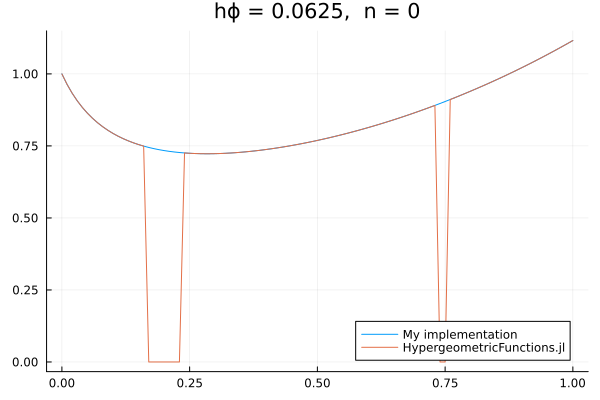

In [9]:
hϕ = 1/16
h_table = collect(0:0.01:1)
n = 0

plot(h_table, hypergeometric4F3(hϕ, h_table, n), label="My implementation")
plot!(h_table, hypergeometricfunction(hϕ, h_table, n), label="HypergeometricFunctions.jl")
title!("hϕ = $hϕ,  n = $n")

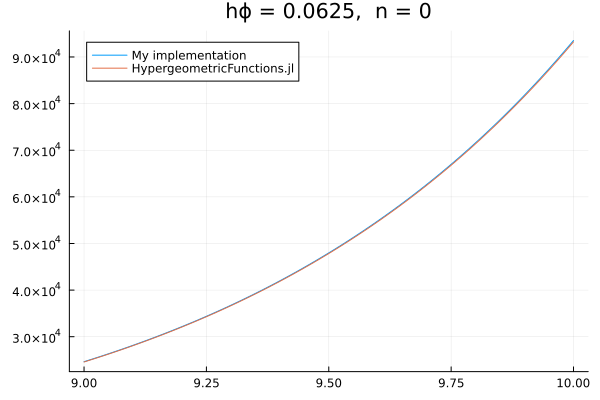

In [10]:
hϕ = 1/16
h_table = collect(9:0.01:10)
n = 0

plot(h_table, hypergeometric4F3(hϕ, h_table, n), label="My implementation")
plot!(h_table, hypergeometricfunction(hϕ, h_table, n), label="HypergeometricFunctions.jl")
title!("hϕ = $hϕ,  n = $n")

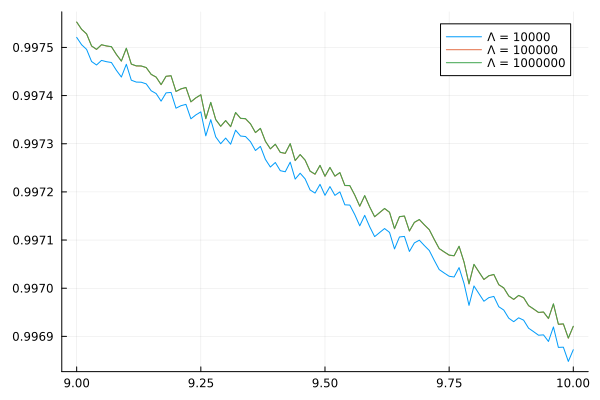

In [11]:
hϕ = 1/16
h_table = collect(9:0.01:10)
n = 0

ref = hypergeometricfunction(hϕ, h_table, n)
plot()
for Λ in [10_000, 100_000, 1_000_000]
    plot!(h_table, ref ./ hypergeometric4F3(hϕ, h_table, n, truncation=Λ), label="Λ = $Λ")
end
plot!()

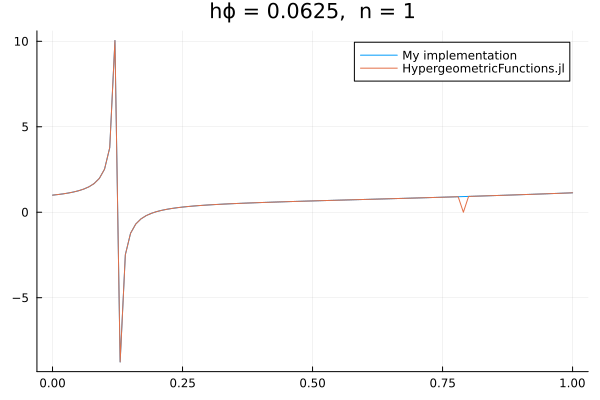

In [12]:
hϕ = 1/16
h_table = collect(0:0.01:1)
n = 1

plot(h_table, hypergeometric4F3(hϕ, h_table, n), label="My implementation")
plot!(h_table, hypergeometricfunction(hϕ, h_table, n), label="HypergeometricFunctions.jl")
title!("hϕ = $hϕ,  n = $n")

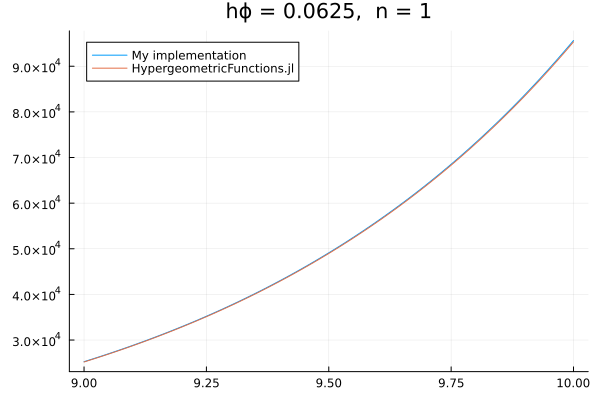

In [13]:
hϕ = 1/16
h_table = collect(9:0.01:10)
n = 1

plot(h_table, hypergeometric4F3(hϕ, h_table, n), label="My implementation")
plot!(h_table, hypergeometricfunction(hϕ, h_table, n), label="HypergeometricFunctions.jl")
title!("hϕ = $hϕ,  n = $n")

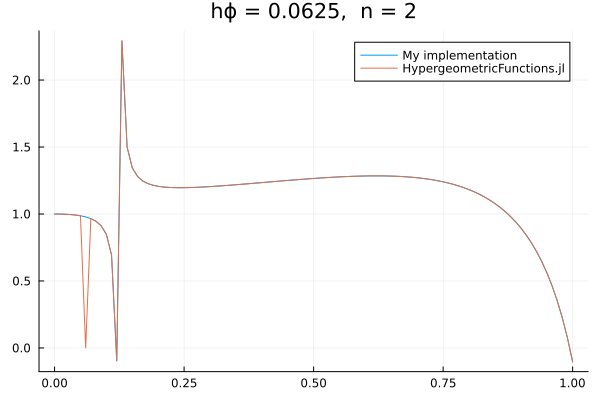

In [14]:
hϕ = 1/16
h_table = collect(0:0.01:1)
n = 2

plot(h_table, hypergeometric4F3(hϕ, h_table, n), label="My implementation")
plot!(h_table, hypergeometricfunction(hϕ, h_table, n), label="HypergeometricFunctions.jl")
title!("hϕ = $hϕ,  n = $n")

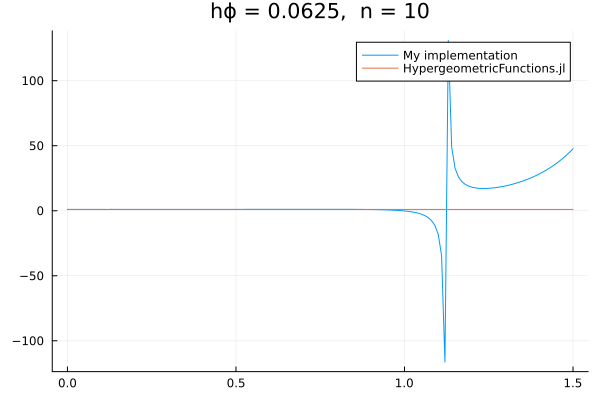

In [15]:
hϕ = 1/16
h_table = collect(0:0.01:1.5)
n = 10

plot(h_table, hypergeometric4F3(hϕ, h_table, n), label="My implementation")
plot!(h_table, hypergeometricfunction(hϕ, h_table, n), label="HypergeometricFunctions.jl")
title!("hϕ = $hϕ,  n = $n")

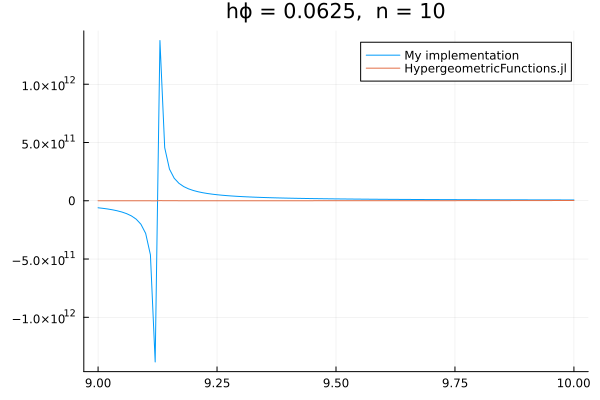

In [16]:
hϕ = 1/16
h_table = collect(9:0.01:10)
n = 10

plot(h_table, hypergeometric4F3(hϕ, h_table, n), label="My implementation")
plot!(h_table, hypergeometricfunction(hϕ, h_table, n), label="HypergeometricFunctions.jl")
title!("hϕ = $hϕ,  n = $n")